In [9]:
import torch
import math
from ksddescent import ksdd_lbfgs, ksdd_gradient
from ksddescent.contenders import svgd, mmd_lbfgs
import matplotlib.pyplot as plt
import numpy as np

from ksd_descent_gaussian import ksdd_lbfgs_gaussian


def score(x):
    return -x / 0.3

def potential(x):
    return (x ** 2).sum(dim=1)


# seems to be the target
def sampler(n_points):
    return math.sqrt(0.3) * torch.randn(n_points, 2)


n_samples = 200
p = 2 # dimension

# Define initial parameters for the Gaussian distribution
m0 = torch.tensor([2.5, 6.0])  # mean
L0 = torch.tensor([[1.5, 0.0], [0.4, 0.4]])  # lower triangular matrix for covariance

bw = 0.1 # bandwidth of the kernel

# call the Gaussian KSD descent
m_ksd, L_ksd, m_traj, L_traj, _ = ksdd_lbfgs_gaussian(m0.clone(), L0.clone(), n_samples, score, bw=bw, store=True)



# Plots

In [10]:
# # Visualize the Gaussian distribution defined by m_ksd and L_ksd

# # Generate a grid of points
# x_ = np.linspace(-1.2, 1.2, 100)
# y_ = np.linspace(-1.2, 1.2, 100)
# X, Y = np.meshgrid(x_, y_)
# XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T, dtype=torch.float32)

# # Compute the Gaussian density
# cov_ksd = torch.matmul(L_ksd, L_ksd.T)
# inv_cov_ksd = torch.inverse(cov_ksd)
# diff = XX - m_ksd
# exponent = -0.5 * torch.sum(diff @ inv_cov_ksd * diff, dim=1)
# Z = torch.exp(exponent).reshape(X.shape).detach().numpy()

# # Plot the Gaussian density
# plt.figure(figsize=(6, 6))
# plt.contourf(X, Y, Z, levels=20, cmap="viridis")
# plt.colorbar(label="Density")
# plt.scatter(m_ksd[0], m_ksd[1], color="red", label="Mean (m_ksd)")
# plt.title("Final Gaussian Distribution with KSD-optimized Parameters")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.legend()
# plt.show()



In [11]:
# # make another plot. this time, we plot the contour of the Gaussian within one standard deviation
# # Plot the contour of the Gaussian within one standard deviation
# plt.figure(figsize=(6, 6))
# # plt.contourf(X, Y, Z, levels=20, cmap="viridis")
# # plt.colorbar(label="Density")
# plt.contour(X, Y, Z, levels=[np.exp(-0.5)], colors="red", linestyles="dashed", label="1 Std Dev Contour")
# plt.scatter(m_ksd[0], m_ksd[1], color="red", label="Mean (m_ksd)")
# plt.title("Final Gaussian Distribution with KSD-optimized Parameters (1 Std Dev Contour)")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.legend()
# plt.show()


# Now, let's plot the trajectories

In [12]:
# Check the length of m_traj and L_traj
print("Length of m_traj:", len(m_traj))
print("Length of L_traj:", len(L_traj))


Length of m_traj: 21
Length of L_traj: 21


In [13]:
# Print the content of m_traj
for i, m in enumerate(m_traj):
    print(f"Iteration {i}: m = {m}")


Iteration 0: m = tensor([2.4419, 5.8549])
Iteration 1: m = tensor([2.4392, 5.8485])
Iteration 2: m = tensor([2.4167, 5.7680])
Iteration 3: m = tensor([2.2076, 5.1674])
Iteration 4: m = tensor([1.9550, 4.5278])
Iteration 5: m = tensor([1.5899, 3.5074])
Iteration 6: m = tensor([0.1190, 0.7191])
Iteration 7: m = tensor([-0.2608,  0.0042])
Iteration 8: m = tensor([-0.2816, -0.7003])
Iteration 9: m = tensor([ 0.0084, -0.3570])
Iteration 10: m = tensor([ 0.0317, -0.2953])
Iteration 11: m = tensor([ 0.1524, -0.0390])
Iteration 12: m = tensor([0.2214, 0.1183])
Iteration 13: m = tensor([0.2716, 0.1273])
Iteration 14: m = tensor([0.2203, 0.0938])
Iteration 15: m = tensor([ 0.0611, -0.0231])
Iteration 16: m = tensor([ 0.0528, -0.0308])
Iteration 17: m = tensor([ 0.0528, -0.0308])
Iteration 18: m = tensor([ 0.0419, -0.0816])
Iteration 19: m = tensor([ 0.0772, -0.0481])
Iteration 20: m = tensor([0.1457, 0.1172])


In [14]:
# why is only three iterations recorded?

/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_58151/2529268017.py:21: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[np.exp(-0.5)], colors="red", linestyles="dashed", label=f"1 Std Dev Contour (Iteration {i})")


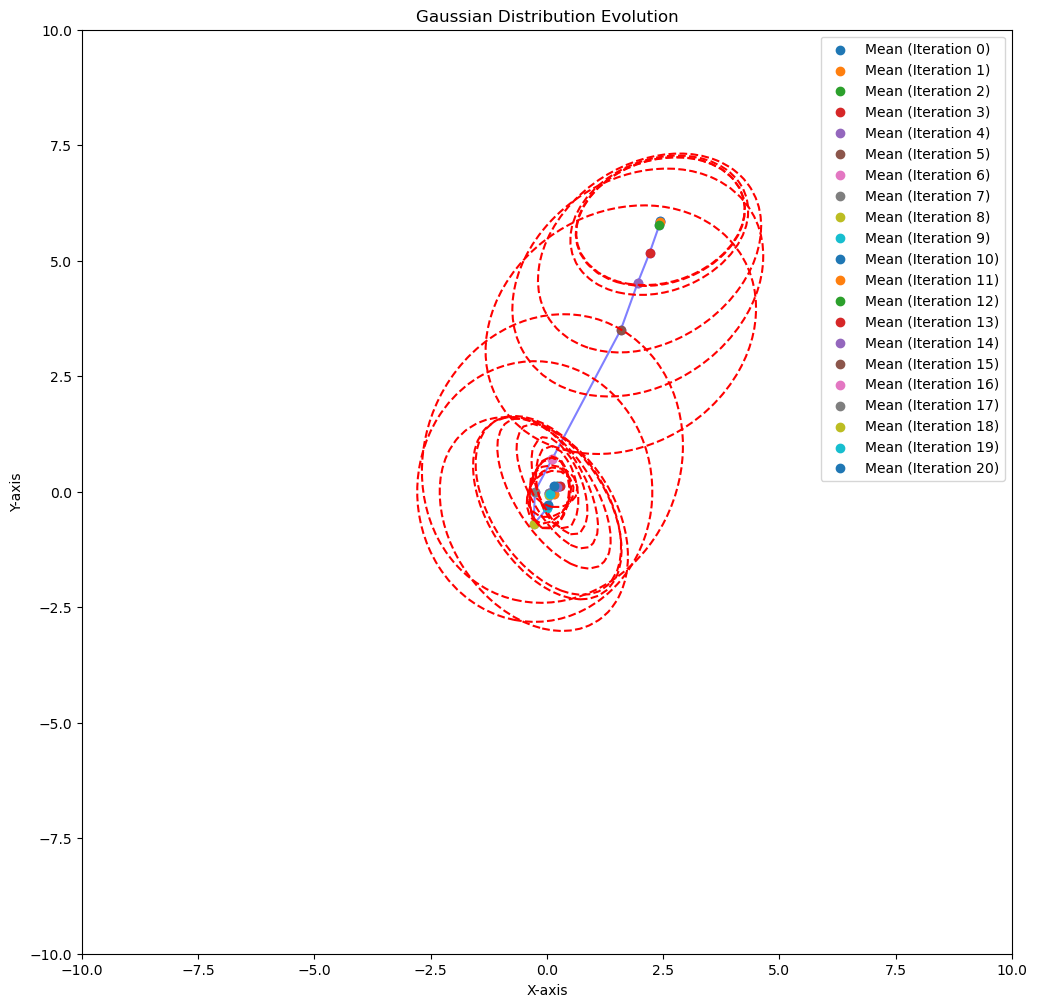

In [15]:
# Plot the evolution of the Gaussian distributions using the mean and Cholesky factor of covariance stored in the lists m_traj, L_traj

plt.figure(figsize=(12, 12))  # Make the plot figure size larger

# Extract the means from m_traj for plotting the trajectory
means = np.array([m.detach().numpy() for m in m_traj])

# Create a grid of points for plotting the Gaussian density
X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
XX = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)

for i, (m, L) in enumerate(zip(m_traj, L_traj)):
    # Compute the Gaussian density for the current mean and covariance
    cov = torch.matmul(L, L.T)
    inv_cov = torch.inverse(cov)
    diff = XX - m
    exponent = -0.5 * torch.sum(diff @ inv_cov * diff, dim=1)
    Z = torch.exp(exponent).reshape(X.shape).detach().numpy()
    
    # Plot only one contour line
    plt.contour(X, Y, Z, levels=[np.exp(-0.5)], colors="red", linestyles="dashed", label=f"1 Std Dev Contour (Iteration {i})")
    plt.scatter(m[0], m[1], label=f"Mean (Iteration {i})")

# Plot the trajectory line connecting the means
plt.plot(means[:, 0], means[:, 1], color="blue", linestyle="-", marker="o", alpha=0.5, zorder=0)

plt.title("Gaussian Distribution Evolution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xlim(-10, 10)  # Set x limits larger to show all plots
plt.ylim(-10, 10)  # Set y limits larger to show all plots
plt.legend()
plt.show()


TODO: use the potential function, plot the target Gaussian density

/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_58151/2904171009.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_target, levels=[np.exp(-0.5)], colors="black", linewidths=2, label="1 Std Dev Contour (True Distribution)")


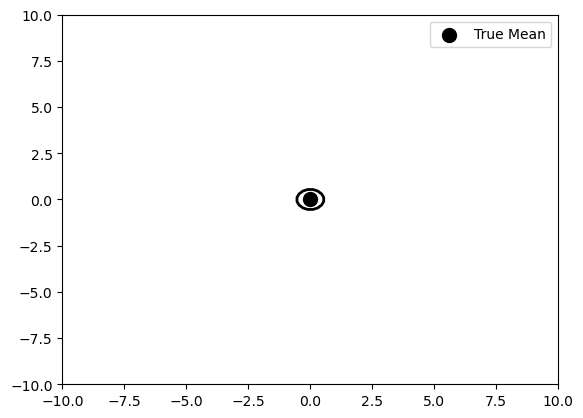

In [18]:
# Get the target Gaussian distribution information from the sampler function
target_mean = torch.zeros(2)
target_cov = 0.3 * torch.eye(2)
target_inv_cov = torch.inverse(target_cov)

# Compute the Gaussian density for the target distribution
diff = XX - target_mean
exponent = -0.5 * torch.sum(diff @ target_inv_cov * diff, dim=1)
Z_target = torch.exp(exponent).reshape(X.shape).detach().numpy()

# Plot the target distribution with a solid black contour
plt.contour(X, Y, Z_target, levels=[np.exp(-0.5)], colors="black", linewidths=2, label="1 Std Dev Contour (True Distribution)")

# Add a scatter point for the target mean
plt.scatter(target_mean[0], target_mean[1], color="black", s=100, label="True Mean")

plt.legend()
plt.show()


# plot the performance metric
we use the reverse KL, ie
$$
\mathcal{D}_{KL}( \pi | \hat \mu_t ) = \int \pi(x) \log \frac{\pi(x)}{\hat \mu_t(x)} dx
$$
where $\pi$ is the target distribution, and $\hat \mu_t$ is the distribution following our inference trajectory at time $t$.

